## Введение в спортивный анализ данных, Exploration Data Analysis

Урок 1



In [ ]:
# !pip install missingno

In [2]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [3]:
from google.colab import drive

In [4]:
drive.mount("/content/for_colab")

Mounted at /content/for_colab


In [5]:
!unzip "/content/for_colab/My Drive/for_colab/assignment1_data.zip" -d /content/data

Archive:  /content/for_colab/My Drive/for_colab/assignment1_data.zip
  inflating: /content/data/test.csv  
  inflating: /content/data/__MACOSX/._test.csv  
  inflating: /content/data/train.csv  
  inflating: /content/data/__MACOSX/._train.csv  


## Задание 1:
Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [7]:
train.describe()

target          var_0  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean        0.100490      10.679914  ...      15.870720      -3.326537
std         0.300653       3.040051  ...       3.010945      10.438015
min         0.000000       0.408400  ...       6.299300     -38.852800
25%         0.000000       8.453850  ...      13.829700     -11.208475
50%         0.000000      10.524750  ...      15.934050      -2.819550
75%         0.000000      12.758200  ...      18.064725       4.836800
max         1.000000      20.315000  ...      26.079100      28.500700

[8 rows x 201 columns]

In [8]:
train.head()

ID_code  target    var_0   var_1  ...  var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863  ...   7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473  ...   8.1267   8.7889  18.3560   1.9518
2  train_2       0   8.6093 -2.7457  ...  -6.5213   8.2675  14.7222   0.3965
3  train_3       0  11.0604 -2.1518  ...  -2.9275  10.2922  17.9697  -8.9996
4  train_4       0   9.8369 -1.4834  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 202 columns]

In [9]:
test.head()

ID_code    var_0    var_1    var_2  ...  var_196  var_197  var_198  var_199
0  test_0  11.0656   7.7798  12.9536  ...   4.3654  10.7200  15.4722  -8.7197
1  test_1   8.5304   1.2543  11.3047  ...  -1.4852   9.8714  19.1293 -20.9760
2  test_2   5.4827 -10.3581  10.1407  ...  -7.1086   7.0618  19.8956 -23.1794
3  test_3   8.5374  -1.3222  12.0220  ...   3.9567   9.2295  13.0168  -4.2108
4  test_4  11.7058  -0.1327  14.1295  ...  -5.1612   7.2882  13.9260  -9.1846

[5 rows x 201 columns]

Анализ числовых признаков

In [10]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [11]:
numerical_features.head(n=5)

target    var_0   var_1    var_2  ...  var_196  var_197  var_198  var_199
0       0   8.9255 -6.7863  11.9081  ...   7.8784   8.5635  12.7803  -1.0914
1       0  11.5006 -4.1473  13.8588  ...   8.1267   8.7889  18.3560   1.9518
2       0   8.6093 -2.7457  12.0805  ...  -6.5213   8.2675  14.7222   0.3965
3       0  11.0604 -2.1518   8.9522  ...  -2.9275  10.2922  17.9697  -8.9996
4       0   9.8369 -1.4834  12.8746  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 201 columns]

В датасете только числовые признаки кроме поля "ID_code"

__Переменные, связанные со временем__



In [12]:
# Это здесь лишнее
year_feature = [
    feature for feature in numerical_features
    if 'Yr' in feature or 'Year' in feature
]

year_feature

# train[year_feature].apply(lambda x: print(x.name, x.unique()), axis=0)

[]

В датасете нет переменных, связанных с датой

## Дискретные признаки

In [13]:
 discrete_feature = [
    feature for feature in numerical_features
    # if len(train[feature].unique())<25 and feature not in year_feature+["Id"]
    if len(train[feature].unique())<25
]

print(f"Discrete Variables Count: {len(discrete_feature)}")
print(f"Discrete Variables Column: {discrete_feature}")

Discrete Variables Count: 1
Discrete Variables Column: ['target']


In [14]:
train[discrete_feature].head()

target
0       0
1       0
2       0
3       0
4       0

## Непрерывные признаки

In [15]:
continuous_feature = [
    feature for feature in numerical_features
    # if feature not in discrete_feature + ["Id"] + year_feature
    if feature not in discrete_feature + ["Id"]
    ]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


Для непрерывные признаков имеет смысл строить гистрограммы распределения или функции распределения, а также зависимость непрерывного признака в разрезе целевой переменной. Кроме того, имеет смысл строить распределение __одновременно__ и для обучающей выборки, и для тестовой для понимания насколько отличаются распределения.

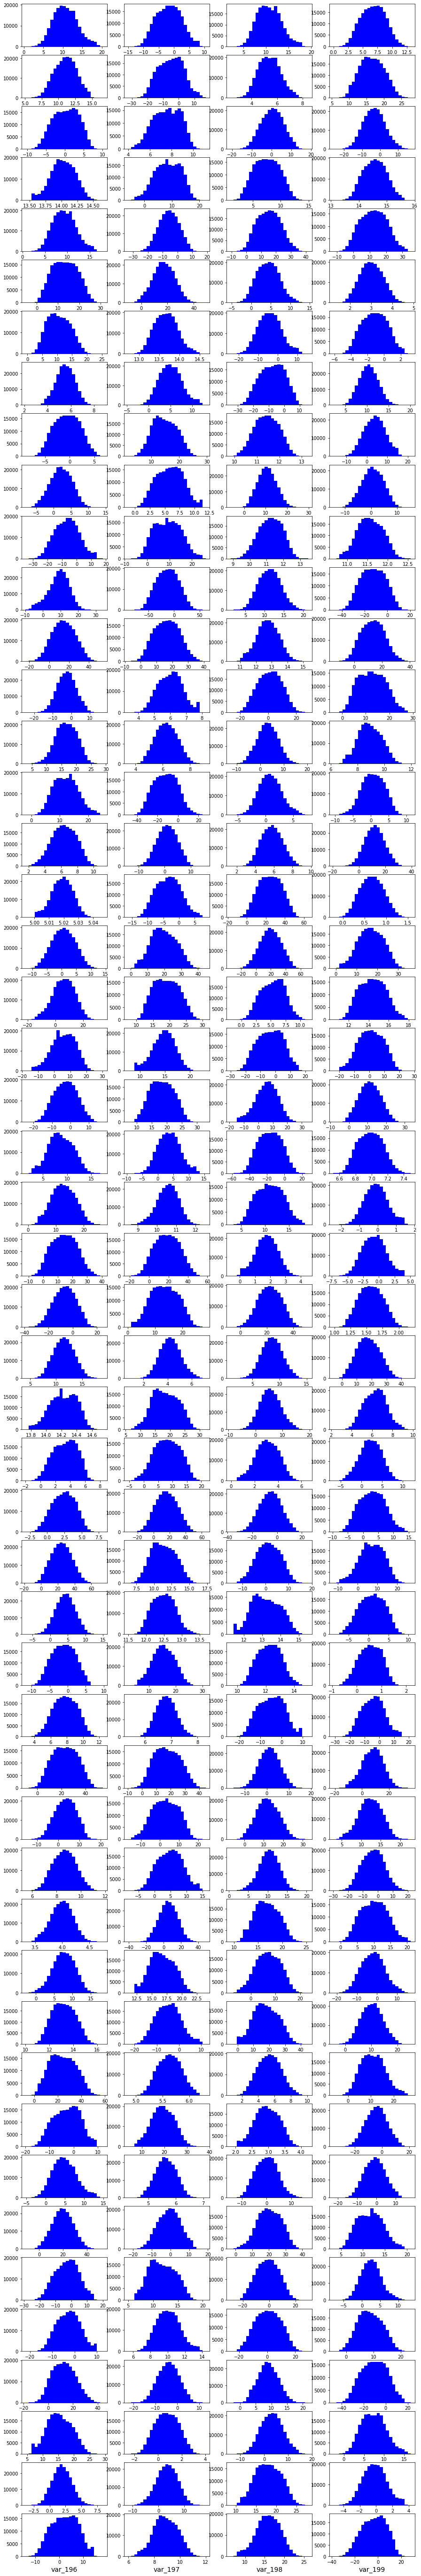

In [16]:
fig, axes = plt.subplots(50, 4, figsize=(15, 100))

for num, feature in enumerate(continuous_feature):
    data = train[feature].copy()
    axes[num//4, num%4].hist(data, bins=25, color="blue")
    axes[num//4, num%4].set_xlabel(feature, fontsize=14)

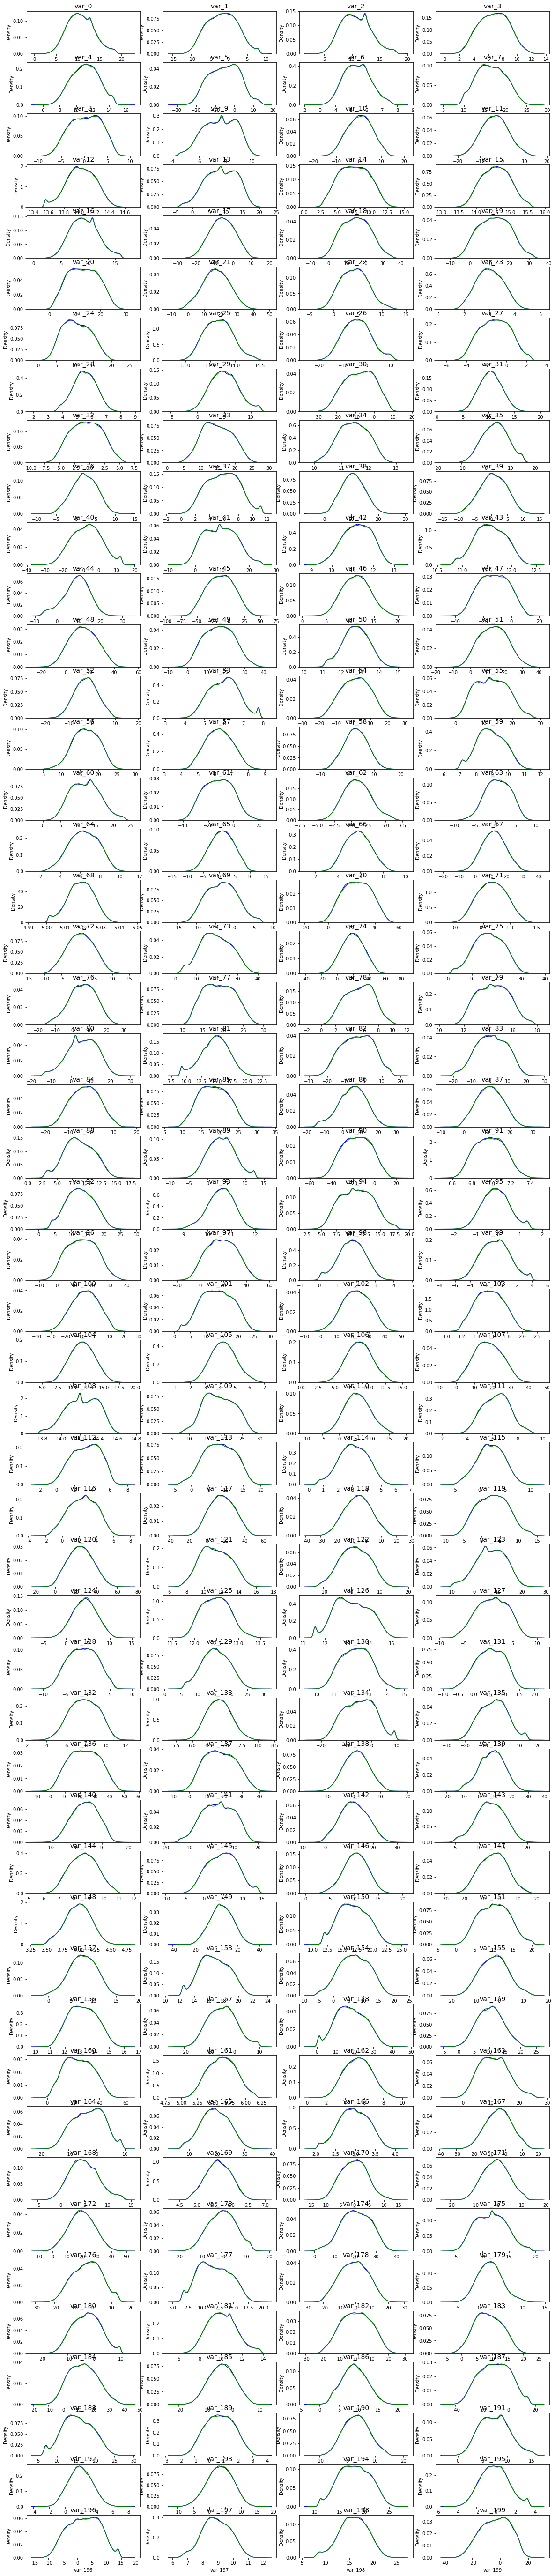

In [17]:
fig, axes = plt.subplots(50, 4, figsize=(20, 100))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)

## Категориальные признаки

In [18]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=2)

Categorical Feature Count 1


ID_code
0  train_0
1  train_1

## Задание 2:
Сделать базовый анализ целевой переменной, сделать выводы;

In [19]:
target = train["target"]
target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

Целевая переменная имеет только два уникальных значения - это 0 и 1.

Количество наблюдений со значением 0 на порядок больше

## Задание 3: 
Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

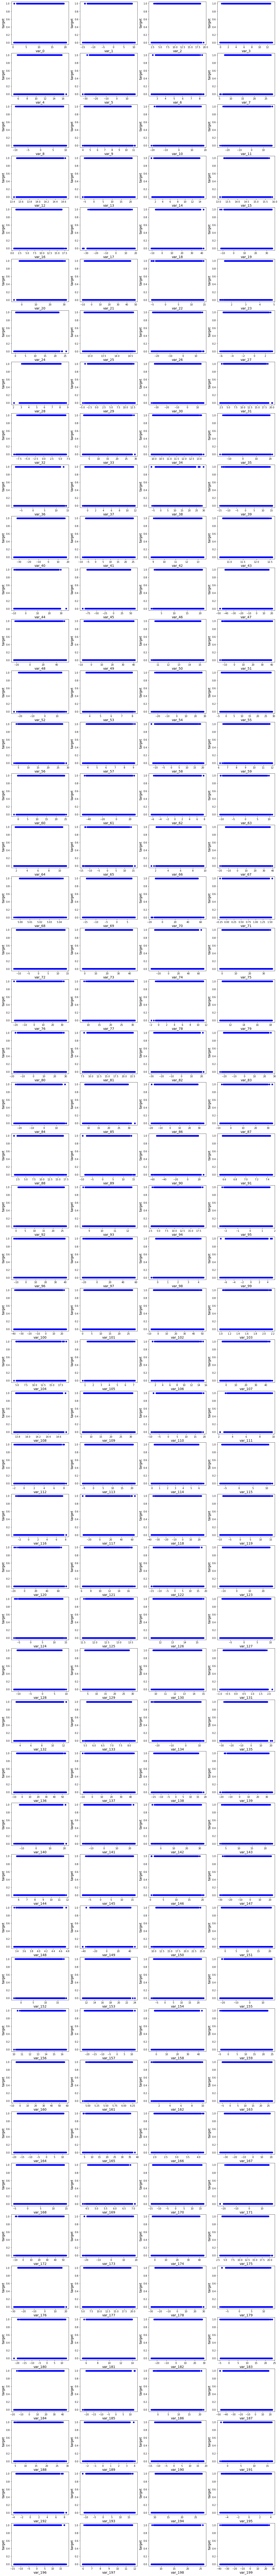

In [20]:
fig, axes = plt.subplots(50, 4, figsize=(20, 200))

for num, feature in enumerate(continuous_feature):
    axes[num//4, num%4].scatter(train[feature], train['target'], color="blue")
    axes[num//4, num%4].set_xlabel(feature, fontsize=14)
    axes[num//4, num%4].set_ylabel('target', fontsize=14)

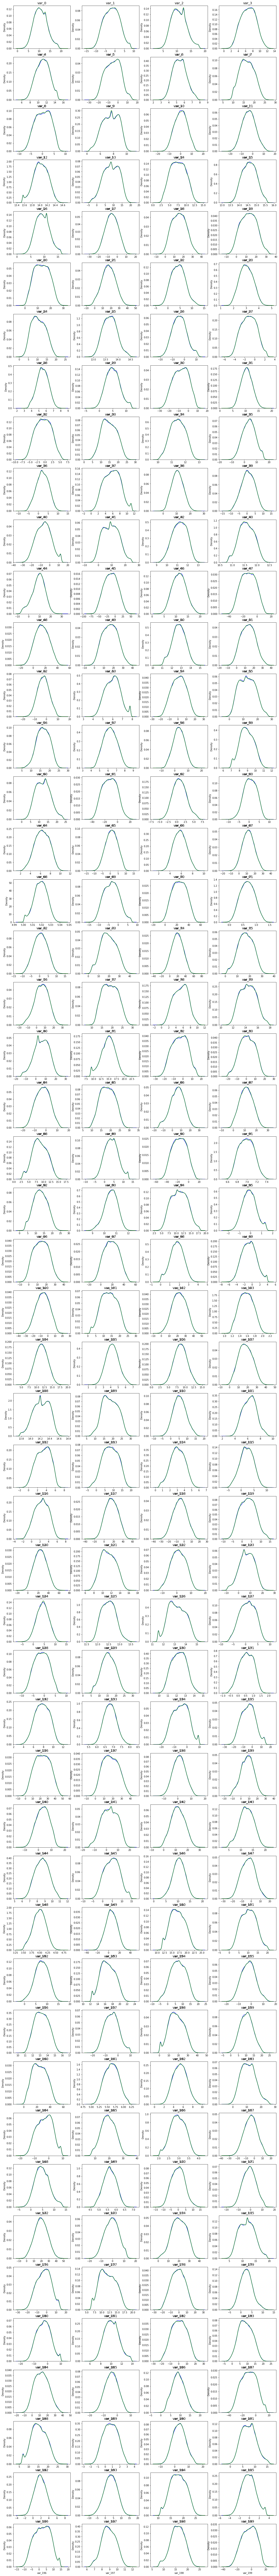

In [21]:
fig, axes = plt.subplots(50, 4, figsize=(20, 200))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)

## Задание 4: 
Построить распределение основных статистик и признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

In [22]:
stats_list = []
for num, feature in enumerate(continuous_feature):
    d = {}
    d["feature_name"] = feature
    d["0_std"] = train[train['target']==0][feature].std()
    d["1_std"] = train[train['target']==1][feature].std()
    d["0_mean"] = train[train['target']==0][feature].mean()
    d["1_mean"] = train[train['target']==1][feature].mean()
    d["train_mean"] = train[feature].mean()
    d["test_mean"] = test[feature].mean()
    d["train_std"] = train[feature].std()
    d["test_std"] = test[feature].std()
    stats_list.append(d)

df_stats_list = pd.DataFrame(stats_list)
df_stats_list

feature_name      0_std      1_std  ...  test_mean  train_std   test_std
0          var_0   3.008564   3.270293  ...  10.658737   3.040051   3.036716
1          var_1   4.024813   4.220638  ...  -1.624244   4.050044   4.040509
2          var_2   2.612961   2.841075  ...  10.707452   2.640894   2.633888
3          var_3   2.040082   2.070898  ...   6.788214   2.043319   2.052724
4          var_4   1.620103   1.649266  ...  11.076399   1.623150   1.616456
..           ...        ...        ...  ...        ...        ...        ...
195      var_195   1.422275   1.485975  ...  -0.133657   1.429372   1.429678
196      var_196   5.441118   5.556892  ...   2.290899   5.454369   5.446346
197      var_197   0.917467   0.952554  ...   8.912428   0.921625   0.920904
198      var_198   2.978539   3.248123  ...  15.869184   3.010945   3.008717
199      var_199  10.434525  10.435910  ...  -3.246342  10.438015  10.398589

[200 rows x 9 columns]

In [23]:
df_stats_columns = df_stats_list.columns
df_stats_columns[1:]

Index(['0_std', '1_std', '0_mean', '1_mean', 'train_mean', 'test_mean',
       'train_std', 'test_std'],
      dtype='object')

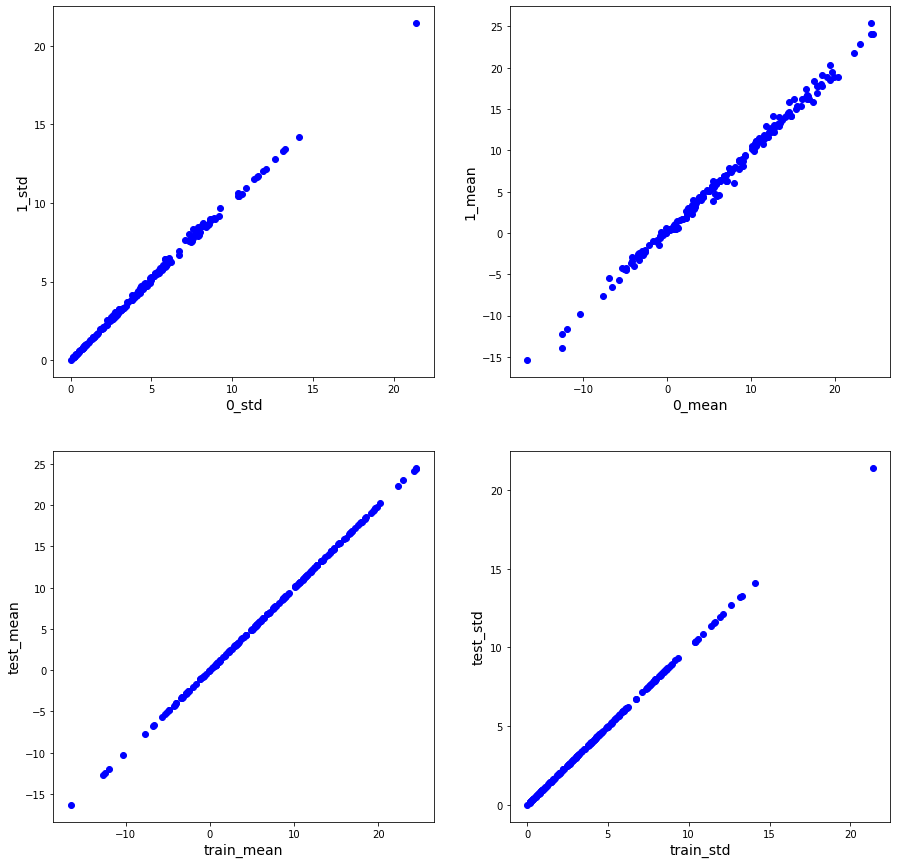

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

num = 0
while num < 4:
  axes[num//2, num%2].scatter(df_stats_list[df_stats_columns[num*2+1]], df_stats_list[df_stats_columns[num*2+2]], color="blue")
  axes[num//2, num%2].set_xlabel(df_stats_columns[num*2+1], fontsize=14)
  axes[num//2, num%2].set_ylabel(df_stats_columns[num*2+2], fontsize=14)
  num += 1

Распределение нормальное. Значения распределения основных статистик обучающей и тестовой выборки примерно идентичны. 
Значения распределения основных статистик и признаков в разрезе целевой переменной тоже примерно равны. У таргета со значением "1" почти всегда немного выше. 

## Задание 5: 
Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

In [25]:
correlation = numerical_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

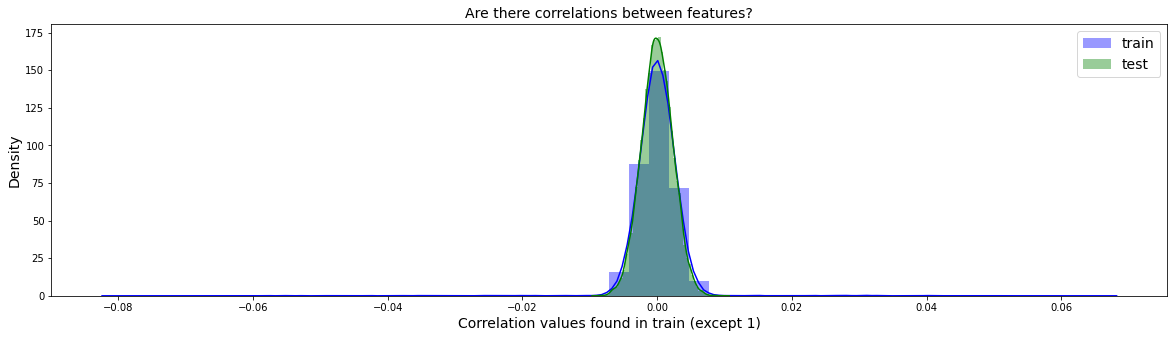

In [26]:
train_correlations = numerical_features.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("target")

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

Коэффициент корреляции < 0.2 - связь между признаками отсутствует

## Correlation Heat Map

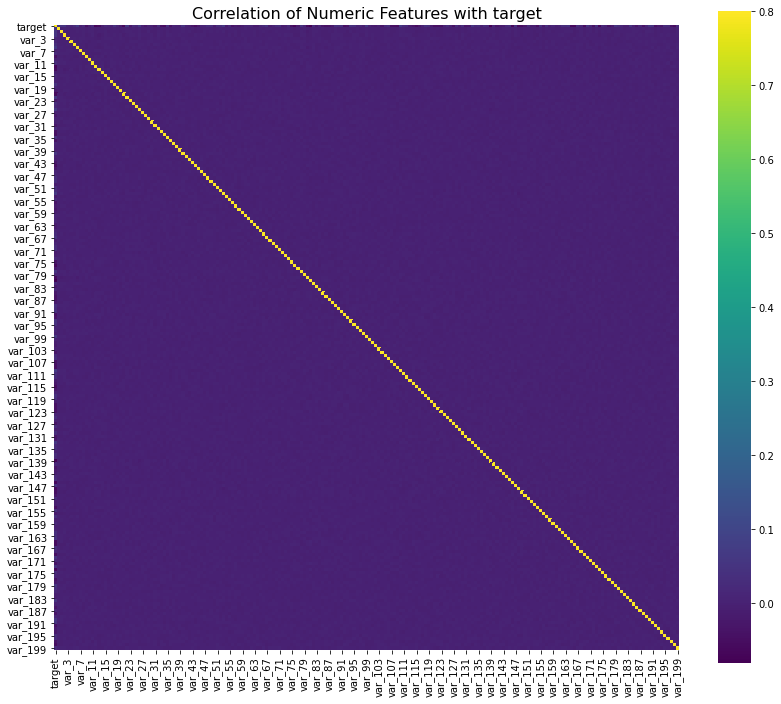

In [27]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with target", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

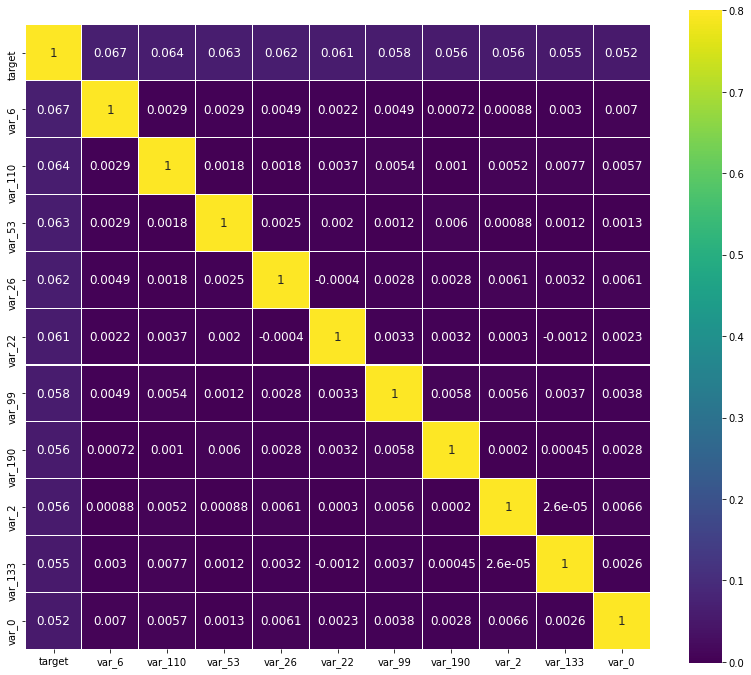

In [28]:
k = 11
cols = correlation.nlargest(k, "target")["target"].index
cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

## Задание 6: 
Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [29]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(numerical_features.fillna(-9999).drop("target", axis=1), target)

CPU times: user 10min 14s, sys: 94.7 ms, total: 10min 14s
Wall time: 5min 19s


Text(0.5, 1.0, 'What are the top important features to start with?')

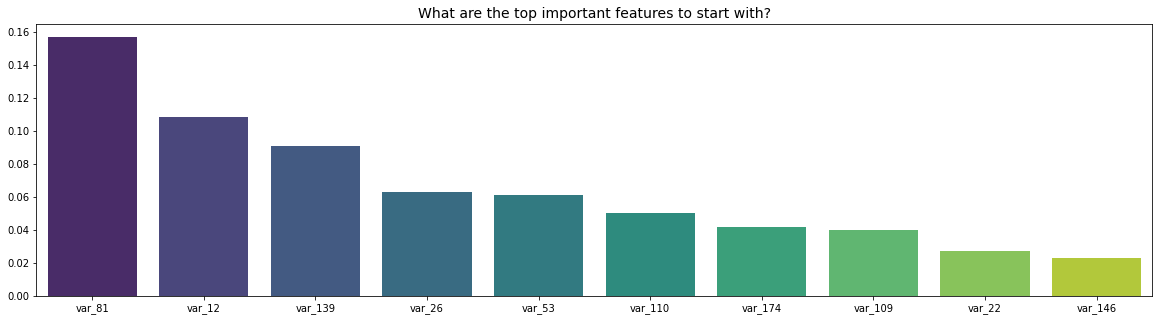

In [30]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.drop("target", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

## Задание 7: 
Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

In [35]:
features_to_score = numerical_features.drop(["target"], axis=1).columns.tolist()

X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [36]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5099
CPU times: user 15min 1s, sys: 1.64 s, total: 15min 3s
Wall time: 7min 35s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

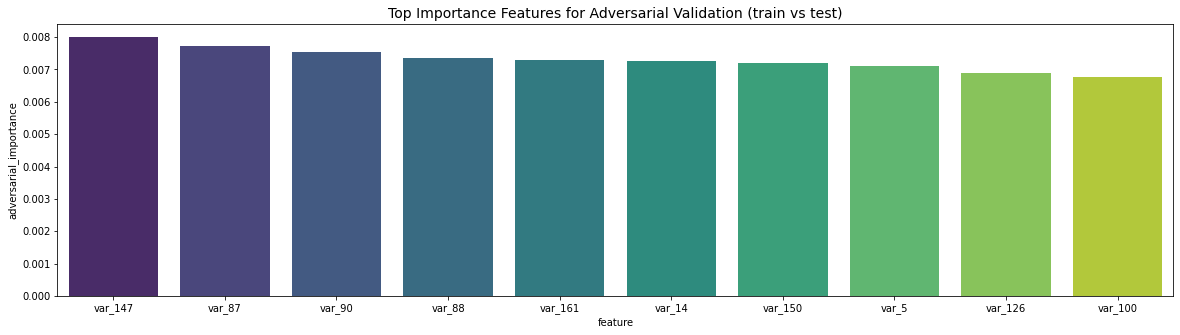

In [37]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

Скорее всего распределения признаков на обучающей и тестовой выборках идентичны. Метрика roc_auc показала результат 0,5